# ALPACA system performance analysis

## Setup

In [64]:
from pathlib import Path
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# plot settings
plt.style.use('seaborn-whitegrid')

# load datasets
likert_datasets = ["credcoalition.csv", "microsoft.csv", "reconcile.csv"]
binary_datasets = ["fnn-gossip.csv", "fnn-politifact.csv"]

likert_per_file = (pd.read_csv(os.path.join(os.getcwd(), "datasets_evaluated", dataset), sep=";",index_col="url") 
                   for dataset in likert_datasets)
binary_per_file = (pd.read_csv(os.path.join(os.getcwd(), "datasets_evaluated", dataset), sep=";",index_col="url") 
                   for dataset in binary_datasets)

likert_df = pd.concat(likert_per_file)
binary_df = pd.concat(binary_per_file)

# group likert ratings into bins
likert_df["rating_bin"] = likert_df.apply(lambda row: 1 if row.rating < 1.5 else 2 if row.rating < 2.5
                                          else 3 if row.rating < 3.5 else 4 if row.rating < 4.5 else 5, axis=1)

# swap 0 <-> 1 fake news classification to facilitate comparisons with credibility ratings (higher rating = better)
binary_df["rating"] = 1 - binary_df["rating"]

# rating distributions
print("\nLikert data: " + str(likert_df.shape) + " urls x values\nRating bins distribution:")
print(likert_df["rating_bin"].value_counts().sort_index().to_string())
print("\nBinary data: " + str(binary_df.shape) + " urls x values\nRatings distribution:")
print(binary_df["rating"].value_counts().sort_index().to_string())


Likert data: (242, 59) urls x values
Rating bins distribution:
1     16
2     24
3     36
4    109
5     57

Binary data: (200, 58) urls x values
Ratings distribution:
0.0    100
1.0    100


## Credibility score analysis

In [2]:
signal = "credibility_score"

minimum = min(likert_df[signal].min(), binary_df[signal].min())
maximum = max(likert_df[signal].max(), binary_df[signal].max())
print(minimum)
print(maximum)

0.1986008169
0.9510424082


#### Scatterplot

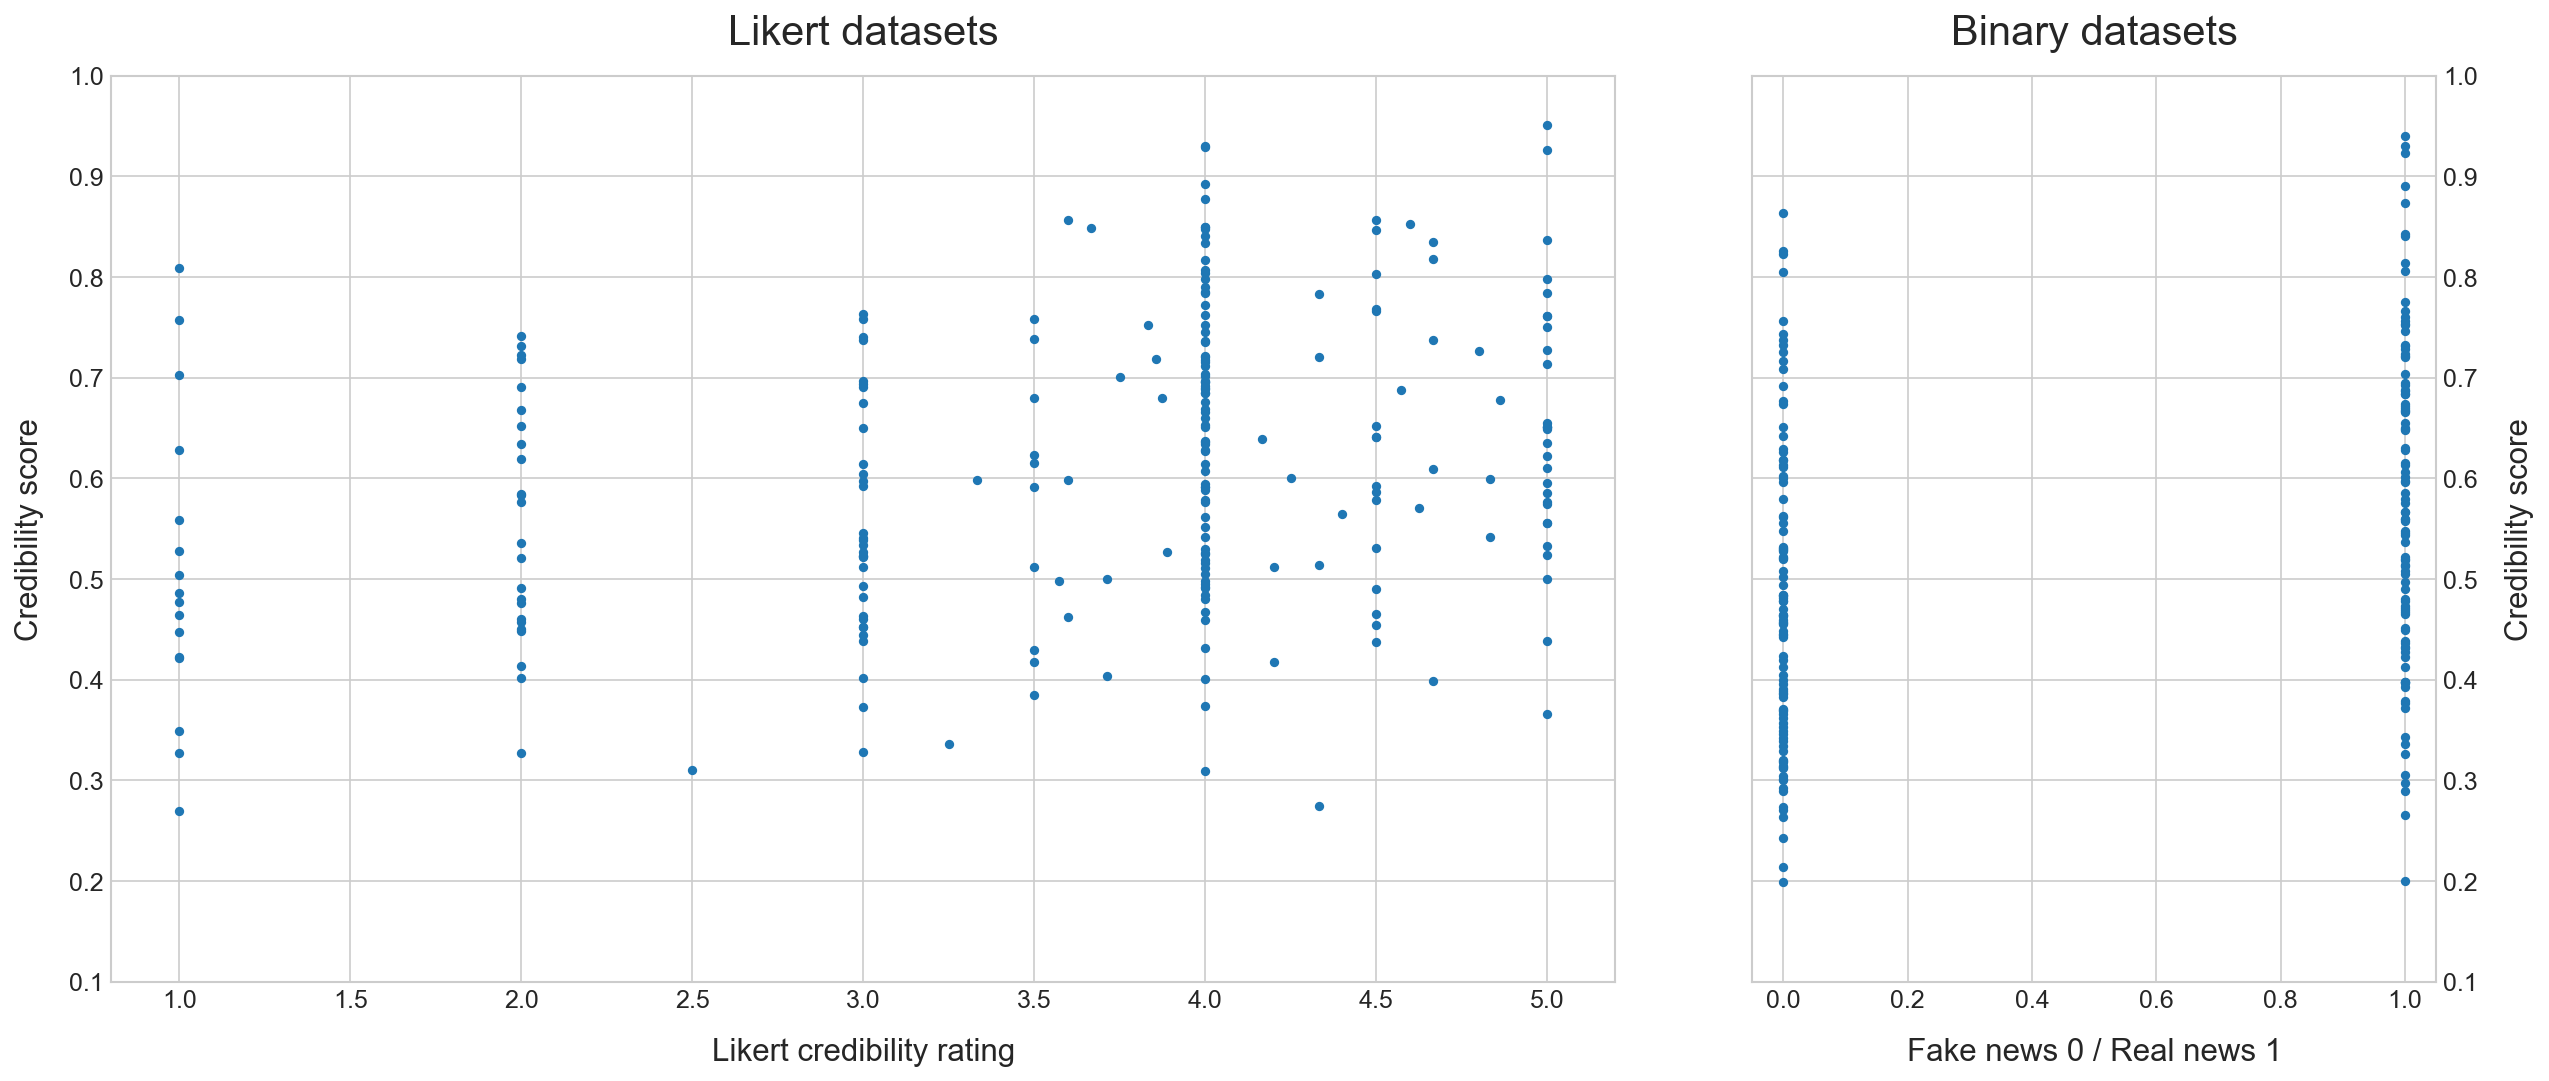

In [58]:
fig = plt.figure(figsize=(20, 8), dpi=150)
ax = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(ax[0, 0:2])
likert_df.plot.scatter("rating", signal, s=12, ax=ax1)
ax1.set_ylim([0.1, 1])
ax1.tick_params(labelsize=12)
ax1.set_title("Likert datasets", size=20, pad=15)
ax1.set_xlabel("Likert credibility rating", size=15, labelpad=12)
ax1.set_ylabel("Credibility score", size=15, labelpad=12)

ax2 = fig.add_subplot(ax[0, 2])
binary_df.plot.scatter("rating", signal, s=12, ax=ax2)
ax2.set_ylim([0.1, 1])
ax2.tick_params(labelsize=12)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_title("Binary datasets", size=20, pad=15)
ax2.set_xlabel("Fake news 0 / Real news 1", size=15, labelpad=12)
ax2.set_ylabel("Credibility score", size=15, labelpad=13)

plt.show()
# plt.savefig("scatter.png", dpi=300)

#### Boxplot

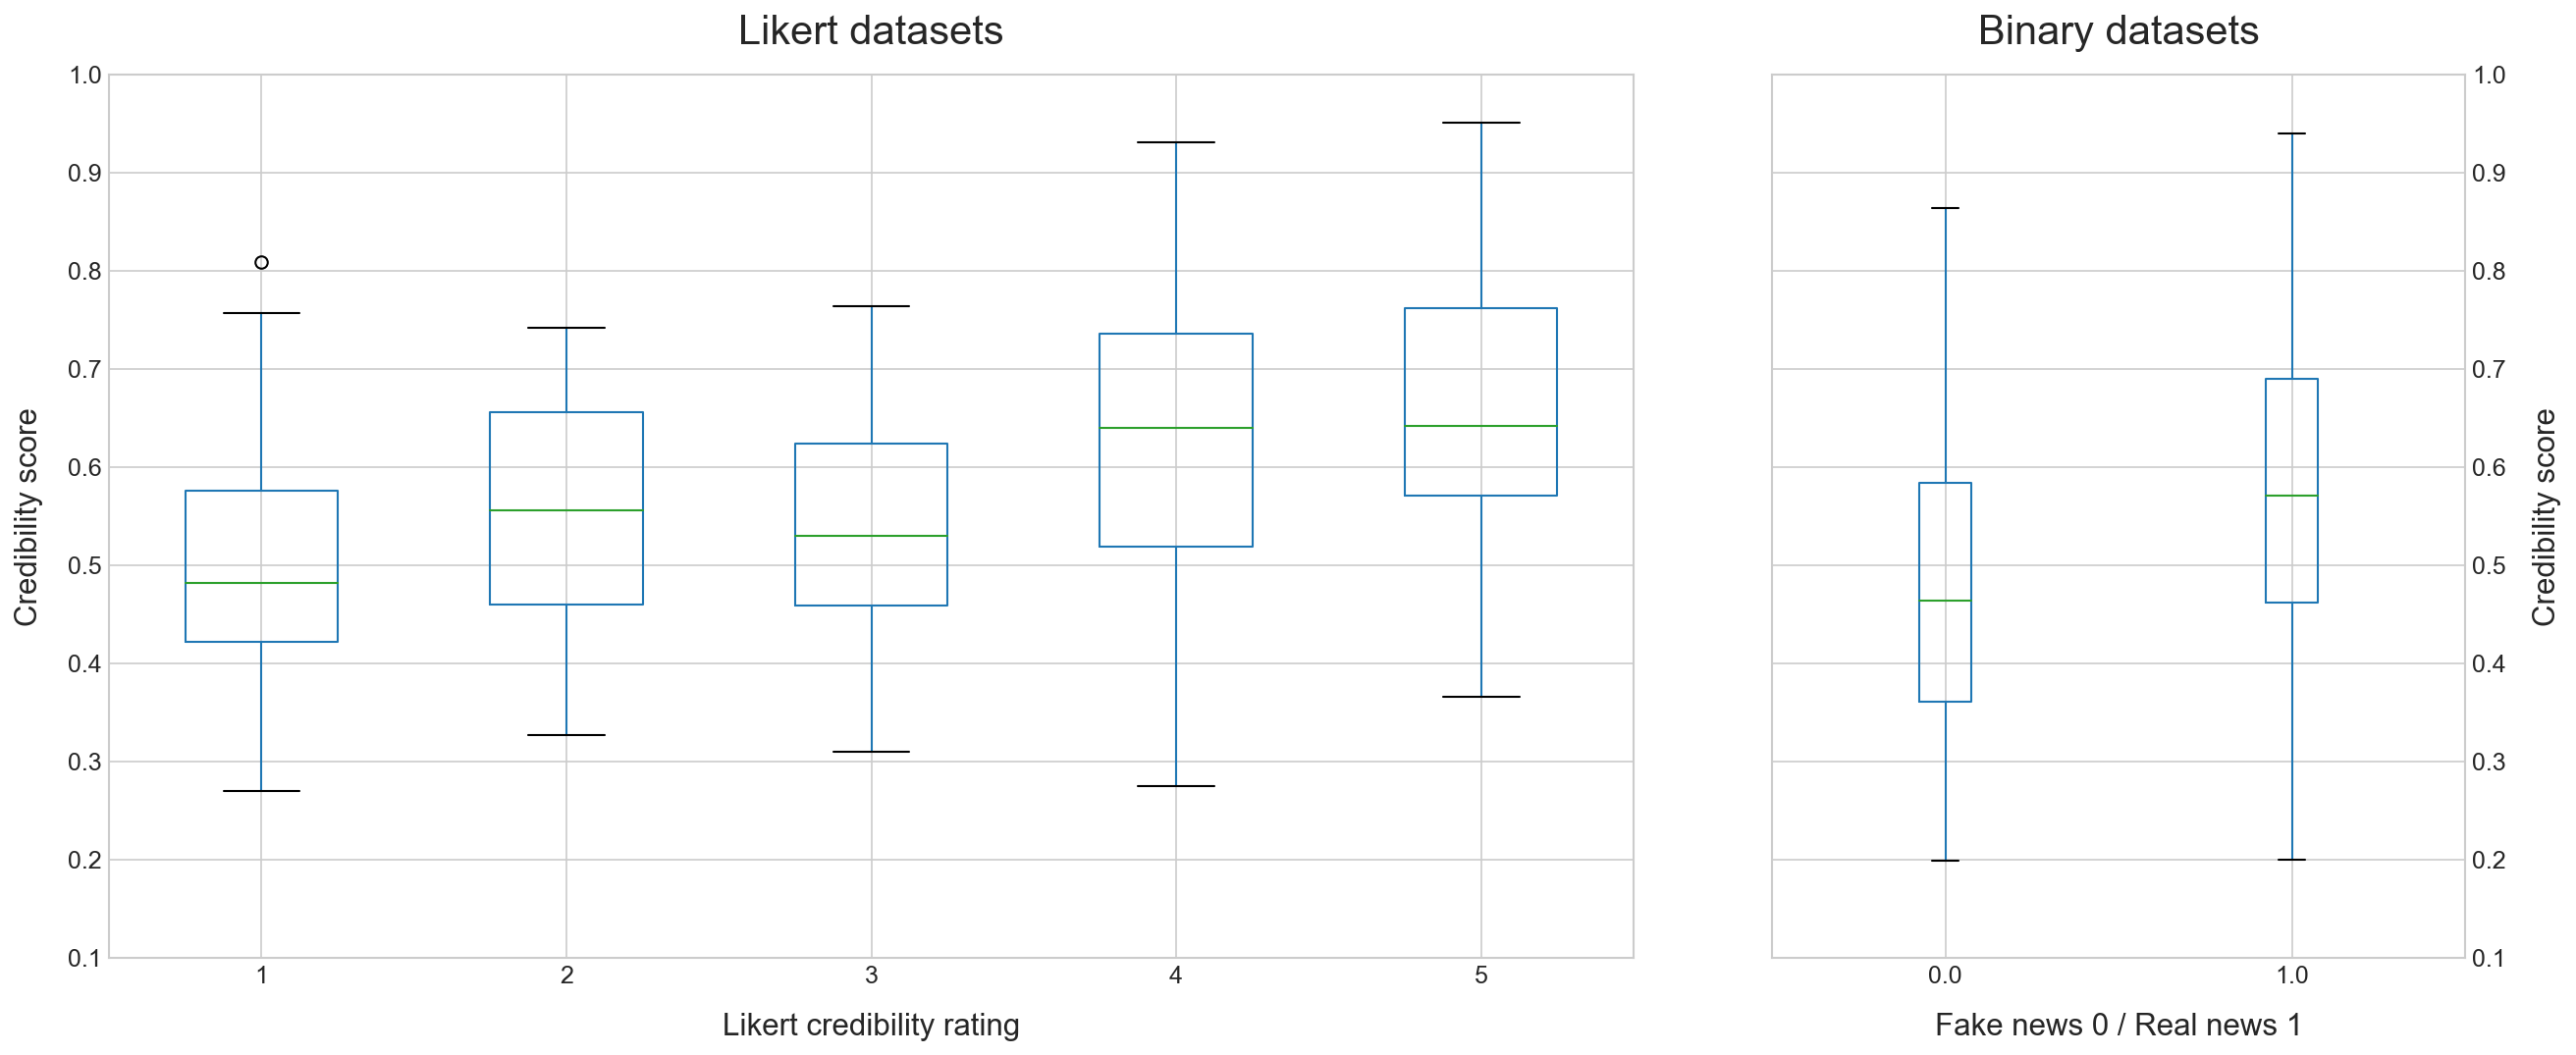

In [67]:
fig = plt.figure(figsize=(20, 8), dpi=150)
ax = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(ax[0, 0:2])
likert_df.boxplot(by="rating_bin", column=signal, ax=ax1)
ax1.set_ylim([0.1, 1])
ax1.tick_params(labelsize=12)
ax1.set_title("Likert datasets", size=20, pad=15)
ax1.set_xlabel("Likert credibility rating", size=15, labelpad=12)
ax1.set_ylabel("Credibility score", size=15, labelpad=12)

ax2 = fig.add_subplot(ax[0, 2])
binary_df.boxplot(by="rating", column=signal, ax=ax2)
ax2.set_ylim([0.1, 1])
ax2.tick_params(labelsize=12)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_title("Binary datasets", size=20, pad=15)
ax2.set_xlabel("Fake news 0 / Real news 1", size=15, labelpad=12)
ax2.set_ylabel("Credibility score", size=15, labelpad=13)

fig.suptitle("")
plt.show()
# plt.savefig("box.png", dpi=300)

#### Mean & median

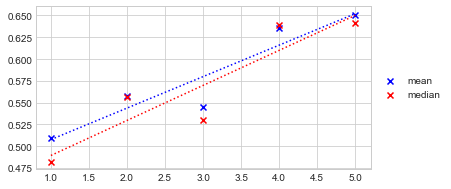

   rating      mean    median
0       1  0.509555  0.481972
1       2  0.557707  0.555942
2       3  0.544805  0.530179
3       4  0.636136  0.639451
4       5  0.650994  0.641253


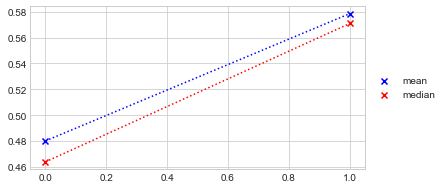

   rating      mean    median
0       0  0.479977  0.463709
1       1  0.578633  0.570997


In [5]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [6]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.2912324858291
Likert p: 4.078943405522864e-06

Binary rho: 0.3015538150439888
Binary p: 1.4291934307500913e-05


## Classification performance

#### Binary data

In [79]:
binary_split = (maximum - minimum) / 2

binary_df["prediction"] = binary_df.apply(lambda row: 0 if row.credibility_score < binary_split else 1, axis=1)
print(binary_df[binary_df["rating"] == binary_df["prediction"]]["rating"].count())

121


#### Likert data

In [ ]:
likert_df["prediction"] = likert_df.apply(lambda row: 
                                          (row.credibility_score - minimum) * 5 / (maximum - minimum))
# TODO